### Imports

In [22]:
from pathlib import Path
import gym
import gym.spaces 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from tqdm import tqdm
import datetime
import random
import pickle
import os
  
import torch
import torch.nn as nn
import torch.optim as optim

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
def set_seed(seed, env):
    env.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Wrappers

In [25]:
class NoopResetEnv(gym.Wrapper):
    """
    Realiza un número random de "NOOP" al invocar reset().
    """
    def __init__(self, env, noop_max=30):
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.noop_action = 0
        assert self.env.unwrapped.get_action_meanings()[0] == 'NOOP'
        
    def reset(self):
        self.env.reset()
        noops = self.env.unwrapped.np_random.integers(1, self.noop_max+1)
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset()
        return obs

In [26]:
class MaxAndSkipEnv(gym.Wrapper):
    """
    Salta un número de frames y regresa el valor máximo de cada pixel.
    """
    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip
        self._obs_buffer = np.zeros((self._skip,) + self.env.observation_space.shape, dtype=np.uint8)
        
    def step(self, action):
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, _, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs            
            total_reward += reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)
        return max_frame, total_reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return obs

In [27]:
class TimeLimit(gym.Wrapper):
    """
    Termina el episodio después de un número de pasos.
    Evita que los ambientes entren en un loop o sin moverse.
    """
    def __init__(self, env, max_episode_steps=None):
        super(TimeLimit, self).__init__(env)
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = 0
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info['TimeLimit.truncated'] = True
        return obs, reward, done, info

    def reset(self):
        self._elapsed_steps = 0
        obs = self.env.reset()
        return obs
        

In [28]:
class FireResetEnv(gym.Wrapper):
    """
    Realiza la acción "FIRE" para iniciar los juegos que lo requieran.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = self.env.ale.lives()
        assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(self.env.unwrapped.get_action_meanings()) >= 3
    
    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs
    
    def step(self, action):
        if self.lives > self.env.ale.lives():
            self.lives = self.env.ale.lives()
            action = 1
        obs, reward, done, info = self.env.step(action)
        return obs, reward, done, info

In [29]:
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_r=-1, max_r=1):
        super().__init__(env)
        self.min_r = min_r
        self.max_r = max_r
        
    def reward(self, reward):
        if reward < 0:
            return self.min_r
        elif reward > 0:
            return self.max_r
        else:
            return 0
        
    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        return obs, self.reward(rew), done, info

In [30]:
class WarpFrame(gym.ObservationWrapper):
    """
    Reescala las imágenes a 84x84 y las pasa de RGB a gris.
    """
    def __init__(self, env, width=84, height=84):
        super().__init__(env)
        self._width = width
        self._height = height
        num_colors = 1
        
        new_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (self._height, self._width, num_colors),
            dtype = np.uint8,
        )
        original_space = self.observation_space
        self.observation_space = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3
        
    def observation(self, obs):
        frame = obs
        frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        frame = cv.resize(
            frame, (self._width, self._height), interpolation=cv.INTER_AREA
        )
        obs = frame
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [31]:
class ScaledFloatFrame(gym.ObservationWrapper):
    """
    Reescala de 0-255 a 0-1.
    """
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = self.env.observation_space.shape,
            dtype = np.float32,
        )
    
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return self.observation(obs), reward, done, info
    
    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

In [32]:
class FrameStack(gym.Wrapper):
    """
    Apila los últimos k frames.
    """
    def __init__(self, env, k=4):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        self.observation_space = gym.spaces.Box(
            low = 0,
            high = 255,
            shape = (4,84,84),
            dtype = self.env.observation_space.dtype,
        )
    
    def reset(self):
        obs = self.env.reset()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs()
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        return self._get_obs(), reward, done, info
    
    def _get_obs(self):
        return self.frames

In [33]:
class EpisodicLifeEnv(gym.Wrapper):
    """
    Termina el episodio cuando se pierde una vida, pero solo reinicia si
    se pierden todas.
    """
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.is_done = True
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.is_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            done = True
        self.lives = lives
        return obs, reward, done, info
    
    def reset(self):
        if self.is_done:
            obs = self.env.reset()
        else:
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Creación del ambiente

In [59]:
def make_atari(env_id, frames=4, max_episode_steps=1_000, noop_max=30, skip=4, sample=False, render_mode=None):
    """
    Crea el ambiente especificado, pasándolo por los Wrappers especificados.
    """
    env = gym.make(env_id, render_mode=render_mode)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max)
    env = MaxAndSkipEnv(env, skip)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if sample==False:
        env = ClipReward(env)
    env = WarpFrame(env)
    env = ScaledFloatFrame(env)
    env = FrameStack(env, frames)
    env = EpisodicLifeEnv(env)
    return env

##### TEST

GAME = 'MsPacmanNoFrameskip-v4'
env = make_atari(GAME)

start = env.reset()

start[0].shape

plt.imshow(start[0])
plt.show()

state, _, _, _ = env.step(0)

plt.imshow(state[0])
plt.show()

### DQN

In [35]:
class DQN(nn.Module):
    """
    Red Profunda de Aprendizaje Q (Deep Q Network).
    """
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1,*shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)      

net = DQN(env.observation_space.shape, env.action_space.n).to(device)
net

### Experience Replay

In [36]:
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'next_state'])

class ExperienceReplay:
    """
    Almacena experiencias pasadas que han sido observadas por el agente.
    Las muestras obtenidas sirven para entrenar la red, buscando minimizar el efecto que tiene la correlación entre pasos.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def __len__(self):
        return len(self.buffer)
    
    def append(self, *args):
        self.buffer.append(Experience(*args))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### Agent

In [37]:
class Agent:
    """
     
    """
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()
        
    def _reset(self):
        self.state = self.env.reset()
        self.total_reward = 0.0
        
    def play_step(self, net, epsilon=0.0, device='cuda'):
        done_reward = None
        
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_a = np.array([self.state], copy=False)
            state_v = torch.tensor(state_a).to(device) ### Intentar poner aquí el Flujo Óptico y no en el ambiente
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1) # Devuelve el índice de la acción
            action = int(act_v.item())
        
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        
        self.exp_buffer.append(self.state, action, reward, done, new_state)
        self.state = new_state
        
        if done:
            done_reward = self.total_reward
            self._reset()
        
        return done_reward

### Función de entrenamiento

In [38]:
def training(env_name, replay_memory_size=50_000, max_frames=5_000_000, gamma=0.99, batch_size=32,  \
            learning_rate=0.00025, sync_target_frames=10_000, net_update=4, replay_start_size=50_000, \
            eps_start=1, eps_min=0.1, seed=2109, device='cuda', verbose=True):
    """
    Función de entrenamiento.
    """
    path = "dicts/" + env_name 
    Path(path).mkdir(parents=True, exist_ok=True)
    
    env = make_atari(env_name, max_episode_steps=1_000)
    buffer = ExperienceReplay(replay_memory_size)
    agent = Agent(env, buffer)
    set_seed(seed=seed, env=env)
    
    net        = DQN(env.observation_space.shape, env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    
    epsilon = eps_start
    eps_decay = (eps_start - eps_min) / replay_memory_size
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    total_rewards = []

    best_mean_reward = None
    start_time = datetime.datetime.now()

    for frame in tqdm(range(1, max_frames+1), desc=env_name):        
        reward = agent.play_step(net, epsilon, device)
        
        if reward is not None:
            total_rewards.append(reward)
            mean_reward = np.mean(total_rewards[-100:])
            
            time_passed = datetime.datetime.now() - start_time
            
            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), path + "/" + env_name + "_best.dat")
                best_mean_reward = mean_reward

        if len(buffer) < replay_start_size:
            continue

        epsilon = max(epsilon-eps_decay, eps_min)

        if frame % net_update == 0:
            sardn = buffer.sample(batch_size)
            batch = Experience(*zip(*sardn))
            
            states_v = torch.tensor(np.array(batch.state)).to(device)
            next_states_v = torch.tensor(np.array(batch.next_state)).to(device)
            actions_v = torch.tensor(batch.action).to(device)
            rewards_v = torch.tensor(batch.reward).to(device)
            done_mask = torch.BoolTensor(batch.done).to(device)
            
            state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
            next_state_values = target_net(next_states_v).max(1)[0]
            next_state_values[done_mask] = 0.0
            next_state_values = next_state_values.detach()
            expected_state_action_values = next_state_values*gamma + rewards_v
            
            loss_t = nn.HuberLoss()(state_action_values, expected_state_action_values) # MSELoss()(input,target)

            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()
            
        if frame % sync_target_frames == 0:
            target_net.load_state_dict(net.state_dict())

        if frame % (max_frames / 10) == 0:
            if verbose:
                print("{}:  {} games, best result {:.3f}, mean reward {:.3f}, eps {:.2f}, time {}".format(
                    frame, len(total_rewards), max(total_rewards), mean_reward, epsilon, time_passed))

            torch.save(net.state_dict(), path + "/" + env_name + "_" + str(int((frame)/(max_frames/10))) + ".dat")

    print("Training finished")
    print("{}:  {} games, mean reward {:.3f}, eps {:.2f}, time {}".format(
            frame, len(total_rewards), mean_reward, epsilon, time_passed))
         
    pkl_file = "dicts/" + env_name + "/" + env_name + "_total.pkl"
    with open(pkl_file, 'wb+') as f:
        pickle.dump(total_rewards, f)
    return total_rewards

### TRAINING

In [39]:
GAME_NAME = "MsPacmanNoFrameskip-v4"

In [ ]:
pacman = training(env_name=GAME_NAME)

#### Muestreo

In [60]:
def sample(env_name, model_name, n_samples=100, verbose=True):
    '''
    Obtiene 'n_samples' muestras de la red entrenada.
    '''
    env_name = env_name + 'NoFrameskip-v4'
    model = 'dicts/' + env_name + '/' + env_name + '_'+ str(model_name) + '.dat'
    env = make_atari(env_name, sample=True)
    net = DQN(env.observation_space.shape, env.action_space.n)
    net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))
    
    rewards = np.zeros(n_samples)

    for i in tqdm(range(n_samples), desc=model):
    
        state = env.reset()
        total_reward = 0.0
        
        while True:
            
            state_v = torch.tensor(np.array([state], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            action = np.argmax(q_vals)

            state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                break
        
        if verbose:
            print('Game: {}, Reward: {}'.format(i+1,total_reward))

        rewards[i] = total_reward

    print(sum(rewards)/n_samples)
    return rewards, sum(rewards)/n_samples

In [63]:
rewards = []
GAME_NAME = 'Breakout'
for i in range(10):
    _, rw = sample(GAME_NAME, i+1, n_samples=100, verbose=False)
    rewards.append(rw)

dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_1.dat: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.28


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_2.dat: 100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


0.25


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_3.dat: 100%|██████████| 100/100 [01:33<00:00,  1.08it/s]


0.14


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_4.dat: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


0.21


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_5.dat: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


0.12


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_6.dat: 100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


0.2


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_7.dat: 100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


0.2


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_8.dat: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


0.0


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_9.dat: 100%|██████████| 100/100 [03:47<00:00,  2.27s/it]


0.0


dicts/BreakoutNoFrameskip-v4/BreakoutNoFrameskip-v4_10.dat: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]

0.11


In [65]:
rewards

[0.28, 0.25, 0.14, 0.21, 0.12, 0.2, 0.2, 0.0, 0.0, 0.11]

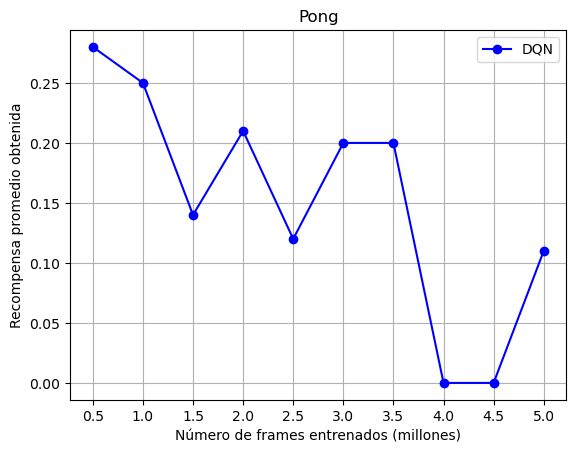

In [64]:
plt.plot([.5,1,1.5,2,2.5,3,3.5,4,4.5,5], rewards, marker='o', linestyle='-', color='b', label='DQN')
plt.xlabel('Número de frames entrenados (millones)')
plt.xticks([.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.ylabel('Recompensa promedio obtenida')
plt.title('Pong')
plt.legend()
plt.grid()
plt.show()

### Visualization

In [ ]:
GAME_NAME = 'MsPacmanNoFrameskip-v4'

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
def make_video(env_name, model_name):
    '''
    Esta función genera un video de una corrida generada por la red entrenada.
    '''
    model = 'dicts/' + env_name + '/' + model_name
    name_video = 'videotest'
    
    env = make_atari(env_name, render_mode='rgb_array')
    video = None
    video = VideoRecorder(env, base_path=name_video, enabled=True)

    net = DQN(env.observation_space.shape, env.action_space.n)
    net.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    state = env.reset()
    total_reward = 0.0
    frame = 1
    
    while True:

        state_v = torch.tensor(np.array([state], copy=False))
        q_vals = net(state_v).data.numpy()[0]
        action = np.argmax(q_vals)
        env.render()
        video.capture_frame()
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        if reward > 0:
            print('{}, reward {}'.format(frame, reward))
            
        if done:
            break
            
        frame += 1
        
    print("Total reward: %.2f" % total_reward)

    video.close()
    video.enabled = False
    env.close()

In [ ]:
make_video(GAME_NAME, os.listdir('dicts/'+GAME_NAME)[0])

67, reward 10.0
70, reward 10.0
73, reward 10.0
77, reward 10.0
80, reward 10.0
83, reward 10.0
Total reward: 60.00
